# ADVANCED LANE FINDING

## CAMERA CALIBRATION

In [1]:
# import all required files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle as pickle
%matplotlib inline

In [2]:
# There are 9*6 corners in image
nx = 9 
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list of filenames, read them in, and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# find distortion parameters by calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

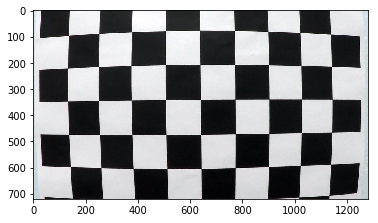

In [3]:
# distorted image
plt.imshow(img)

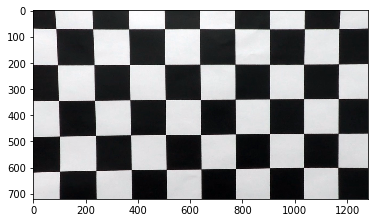

In [4]:
# undistorted image
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

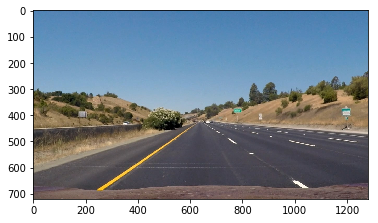

In [5]:
# Now undistort a lane road image
img = plt.imread('test_images/straight_lines1.jpg')
plt.imshow(img, cmap="gray")

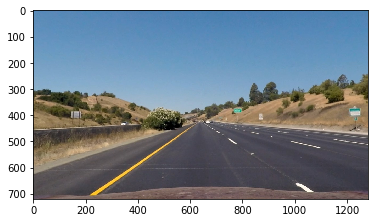

In [6]:
# undistort road image
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

## THRESHOLDED BINARY IMAGE

In [7]:
# original undistorted image
img = undist

In [8]:
def abs_sobel_thresh(img, orient = 'x', thresh=(0, 255)):
    """
    gradient in x and y direction
    """
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # check gradient in x direction
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        
    # check gradient in y direction
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # standardized sobel between 0 and 255
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # threshold check
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    check magnitude of gradient in both x and y direction
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [10]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    check direction of gradient
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [11]:
def color_thresh(img, thresh=(0, 255)):
    """
    check color saturation
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    
    # red channel based thresholds for filtering yellow and white lanes
    r_channel = img[:,:,0]
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1]) & (r_channel >= 200) & (r_channel <= 255)] = 1
    return s_binary

In [12]:
def thresh_bin(img):    
    # combine gradients and color thresholding
    img_sobel_x = abs_sobel_thresh(img, 'x', (50, 150))
    img_sobel_y = abs_sobel_thresh(img, 'y', (75, 150))
    img_sobel_mag = mag_thresh(img, 3, (50, 200))
    img_sobel_dir = dir_thresh(img, 3, (0, np.pi/3))
    img_color = color_thresh(img, (120,250))
    
    combined_grad = np.zeros_like(img_sobel_x)
    combined_grad[((img_sobel_x == 1) & (img_sobel_y == 1)) | ((img_sobel_mag == 1) & (img_sobel_dir == 1))] = 1
    combined = np.zeros_like(combined_grad)
    combined[((combined_grad == 1) | (img_color == 1))] = 1
    return combined

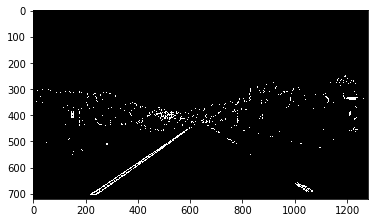

In [13]:
plt.imshow(thresh_bin(img), cmap="gray")

## PERSPECTIVE TRANSFORM

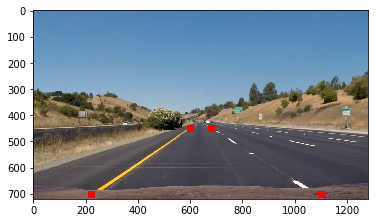

In [14]:
img = plt.imread("test_images/straight_lines1.jpg")
plt.imshow(img)
plt.plot(220, 700, 'rs')
plt.plot(1100, 700, 'rs')
plt.plot(680, 450, 'rs')
plt.plot(600, 450, 'rs')
plt.show()

In [15]:
src = np.float32([[220, 700], [1100, 700], [680, 450], [600, 450]])
dst = np.float32([[300, 700], [1000, 700], [1000, 10], [300, 10]])

In [16]:
img_size = np.shape(img)
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, (img_size[1],img_size[0]), flags=cv2.INTER_LINEAR)

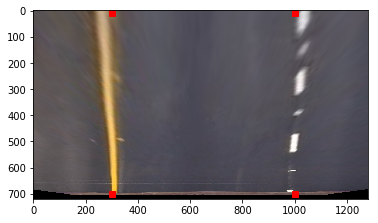

In [17]:
# image after perspective transform
plt.imshow(warped, cmap='gray')
plt.plot(300, 700, 'rs')
plt.plot(1000, 700, 'rs')
plt.plot(1000, 10, 'rs')
plt.plot(300, 10, 'rs')
plt.show()

## LANE FINDING

In [18]:
img = plt.imread("test_images/test2.jpg")

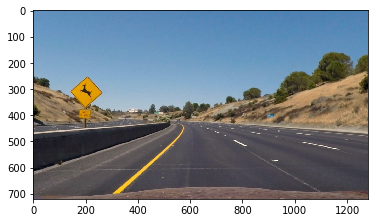

In [19]:
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

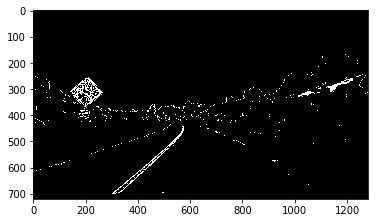

In [20]:
binary = thresh_bin(undist)
plt.imshow(binary, cmap="gray")

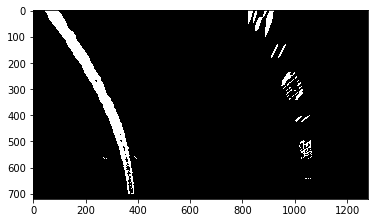

In [21]:
binary_warped = cv2.warpPerspective(binary, M, (img_size[1],img_size[0]), flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')

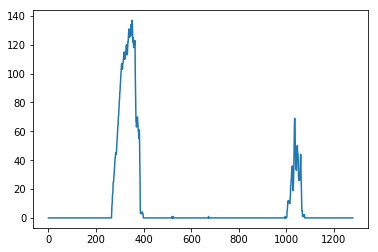

In [22]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [23]:
nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
print(window_height)

80


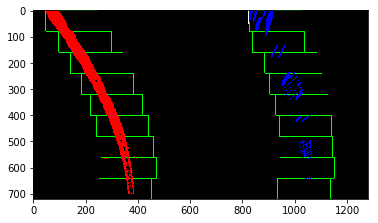

In [24]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
    
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

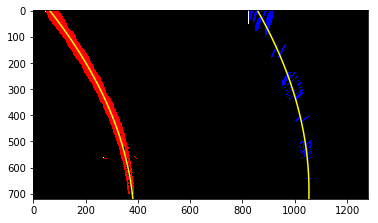

In [25]:
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
# plot left and right lanes
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

## RADIUS OF CURVATURE

In [26]:
y_eval = np.max(ploty)
ym_per_pix = 3/50 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Define conversions in x and y from pixels space to meters
#ym_per_pix = 1 #3/100 # meters per pixel in y dimension
#xm_per_pix = 1 #3.7/600 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
left_curverad = np.round(left_curverad, 2)
right_curverad = np.round(right_curverad, 2)
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
offset = ((1280/2)-((left_fitx[-1] + right_fitx[-1])/2))
offset = np.round(offset*xm_per_pix, 2)
print(offset, 'm')

715.78 m 824.11 m
-0.41 m


## INVERSE PERSPECTIVE TRANSFORMATION

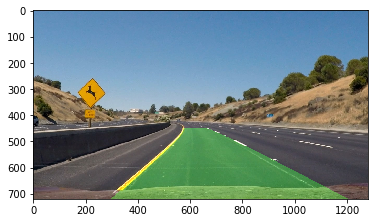

In [27]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))    
cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

Minv = cv2.getPerspectiveTransform(dst, src)
newwarp = cv2.warpPerspective(out_img, Minv, (img.shape[1], img.shape[0]))

result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

## FULL PIPELINE

In [28]:
def findLane(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)  
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))    
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
    out_img = cv2.warpPerspective(out_img, Minv, (img.shape[1], img.shape[0]))

    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    left_curverad = np.round(left_curverad, 2)
    right_curverad = np.round(right_curverad, 2)
    radius = (left_curverad, right_curverad)
    offset = ((1280/2)-((left_fitx[-1] + right_fitx[-1])/2))
    offset = np.round(offset*xm_per_pix, 2)
    return (out_img, radius, offset)

In [29]:
def processImage(img):
    # undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # binary threshold
    binary = thresh_bin(img)
    
    # perspective transform
    img_size = np.shape(img)
    binary_warped = cv2.warpPerspective(binary, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    
    # fine lane with curvature and offset
    (out_img, radius, offset) = findLane(binary_warped)
    result = cv2.addWeighted(img, 1, out_img, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    str_radius = "LEFT RADIUS: " + str(radius[0]) + "m, RIGHT RADIUS: " + str(radius[1]) + "m"
    str_offset = "OFFSET: " + str(offset) + "m"
    
    cv2.putText(result, str_radius, (10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, str_offset, (10,180), font, 1,(255,255,255),2)
    
    return result

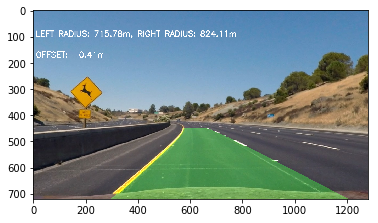

In [ ]:
im1 = processImage(img)
plt.imshow(im1)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1201/1261 [04:25<00:12,  4.65it/s]